# Add an Image: Editor Activation

We investigate the effect of having Add an Image as the default task on whether a newcomer makes an edit within the first 24 hours of registration.

Summary of findings:

* All namespaces, all edits: no difference.
    * Comparing Add an Image to Add a Link: no difference.
* Article & Talk namespaces, all edits: both types of structured tasks increase activation.
    * We find significant differences between the performance of the structured tasks depending on the platform.
    * Desktop: Add a Link increases activation, whereas Add an Image does not. 
    * Mobile web: both tasks significantly increase activation.
    * On both platforms, there is not a significant difference in activation when comparing the two structured tasks directly to each other. This is largely related to French Wikipedia, which is both a large wiki and one where on desktop the two tasks perform comparably.
* All namespaces, non-reverted edits: same result as for all edits.
* Article & Talk namespaces, non-reverted edits: both types of structured tasks increase activation.
    * We find similar platform differences as before. The relative effect difference on desktop is larger, although not statistically significant. This could point to Add a Link being a better newcomer task on desktop, or that Add an Image will be a better task when the Section-Level Image Suggestion design changes are implemented.

In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

library(lme4)
library(yardstick) # install.packages("yardstick")

library(caret)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [6]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-an-image-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c()

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add an Image on each of the wikis
## This is not relevant for this, because we "reset" the experiment and
## gather data well after deployment.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 148419

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [ ]:
user_edit_data |>
    group_by(reg_on_mobile, hp_enabled, hp_variant) |>
    summarize(n = n())

In [10]:
user_edit_data <- user_edit_data %>%
    mutate(
        platform = ifelse(reg_on_mobile == 1, 'Mobile web', 'Desktop'),
        exp_group = factor(
            ifelse(
                hp_enabled == 0, 'Control',
                ifelse(hp_variant == 'control',
                       'Add-a-Link', 'Add-an-Image')
            ),
            c('Control', 'Add-a-Link', 'Add-an-Image')
        )
    )

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
user_edit_data %>%
    group_by(wiki_db, platform, exp_group) %>%
    summarize(n = n())

In [46]:
user_edit_data |>
    filter(
        !(wiki_db == 'frwiki' & exp_group == 'Control')
    ) |>
    group_by(exp_group) |>
    summarize(n = n()) |>
    ungroup() |>
    mutate(perc = n/sum(n))

exp_group    n     perc 
1 Control      22011 0.148
2 Add-a-Link   63428 0.427
3 Add-an-Image 62973 0.424

In [47]:
user_edit_data |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    group_by(exp_group) |>
    summarize(n = n()) |>
    ungroup() |>
    mutate(perc = n/sum(n))

exp_group    n     perc 
1 Control      22011 0.199
2 Add-a-Link   44355 0.402
3 Add-an-Image 44023 0.399

In [48]:
user_edit_data |>
    filter(
        (wiki_db == 'frwiki') &
        (exp_group != 'Control')
    ) |>
    group_by(exp_group) |>
    summarize(n = n()) |>
    ungroup() |>
    mutate(perc = n/sum(n))

exp_group    n     perc 
1 Add-a-Link   19073 0.502
2 Add-an-Image 18950 0.498

**Note:** The French Wikipedia deployment did not use a control group. We therefore will have to exclude that wiki for any three-way analysis, but we can include it when we compare Add-an-Image to Add-a-Link.

## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

In [11]:
## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

trainIndex <- caret::createDataPartition(user_edit_data$exp_group,
                                         p = .8,
                                         list = FALSE,
                                         times = 1)
user_data_train = user_edit_data[trainIndex,]
user_data_second = user_edit_data[-trainIndex,]

testIndex = caret::createDataPartition(user_data_second$exp_group, p = .5, list = FALSE, times = 1)

user_data_test = user_data_second[testIndex,]
user_data_validate = user_data_second[-testIndex,]

## Visualizing Activation and Retention

We'll plot bar charts for activation and retention for the Control, Unstructured, and Add-a-link groups, split by platform.

### Activation

In [ ]:
user_edit_data %>%
    group_by(platform, exp_group, is_activated) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_activated == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Overall Activation') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

In [34]:
user_edit_data %>%
    group_by(platform, exp_group, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Overall Constructive Article Activation') +
        scale_fill_discrete(name = "Treatment Group",
                            breaks = c("Control", "Add-an-Image", "Add-a-Link"),
                            labels = c("Control", "Add an Image", "Add a Link")) +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

In [ ]:
user_edit_data %>%
    filter(wiki_db != 'frwiki') |>
    group_by(wiki_db, platform, exp_group, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = exp_group)) +
        labs(title = 'Overall Constructive Article Activation') +
        scale_fill_discrete(name = "Treatment Group",
                            breaks = c("Control", "Add-an-Image", "Add-a-Link"),
                            labels = c("Control", "Add an Image", "Add a Link")) +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
    facet_grid(wiki_db ~ .)

# Fitting Models

## All namespaces, all edits

In [ ]:
blas_set_num_threads(16)
activation.overall.1 <-
    user_data_train |>
    filter(wiki_db != 'frwiki') |>
    glmer(
        formula = is_activated ~ platform + exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(activation.overall.1)

This model appears to correspond relatively well with the graph of overall activation, there is not any significant difference between the three groups.

Let's check for interaction between `platform` and `exp_group`:

In [ ]:
blas_set_num_threads(16)
activation.overall.2 <-
    user_data_train |>
    filter(wiki_db != 'frwiki') |>
    glmer(
        formula = is_activated ~ platform * exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(activation.overall.2)

We don't find evidence of interaction and the AIC/BIC indicates that this model isn't a better fit.

In [ ]:
blas_set_num_threads(16)
activation.overall.3 <-
    user_data_train |>
    filter(wiki_db != 'frwiki') |>
    glmer(
        formula = is_activated ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(activation.overall.3)

The AIC/BIC of this model indicates that it's a much better fit. The population-level effect of `platform` is now only marginally significant.

In [ ]:
blas_set_num_threads(16)
activation.overall.4 <-
    user_data_train |>
    filter(wiki_db != 'frwiki') |>
    glmer(
        formula = is_activated ~ platform + exp_group + (1 + platform + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(activation.overall.4)

This model is singular, so we discard it. This means there's no indication of a meaningful variation between wikis when it comes to the effect of `exp_group`

### Comparing Add an Image to Add a Link

While we saw no difference against the control group, we can also compare the two structured tasks against each other.

Since we already saw group-level effects of `platform` in the previous analysis, we start with that model here.

In [36]:
blas_set_num_threads(16)
structured.activation.overall.1 <-
    user_data_train |>
    filter(exp_group != 'Control') |>
    glmer(
        formula = is_activated ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [37]:
summary(structured.activation.overall.1)

In [38]:
blas_set_num_threads(16)
structured.activation.overall.2 <-
    user_data_train |>
    filter(exp_group != 'Control') |>
    glmer(
        formula = is_activated ~ platform * exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [39]:
summary(structured.activation.overall.2)

We do not see an indication of an interaction effect, and there doesn't appear to be any significant difference between the two structured tasks on overall activation.

## Article & Talk namespaces, all edits

While I expect we'll see a significant improvement when `platform` is allowed to have group-level variation, I'll leave it out for now. If it does show up, it'll become the default model for all subsequent analyses.

In [40]:
blas_set_num_threads(16)
activation.article.1 <-
    user_data_train |>
    filter(wiki_db != 'frwiki') |>
    glmer(
        formula = is_activated_article ~ platform + exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [41]:
summary(activation.article.1)

In [44]:
blas_set_num_threads(16)
activation.article.2 <-
    user_data_train |>
    filter(wiki_db != 'frwiki') |>
    glmer(
        formula = is_activated_article ~ platform * exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [111]:
summary(activation.article.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ platform * exp_group + (1 | wiki_db)
   Data: filter(user_data_train, wiki_db != "frwiki")

     AIC      BIC   logLik deviance df.resid 
   99611    99677   -49798    99597    88327 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.786 -0.702 -0.452  1.274  2.324 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.212    0.461   
Number of obs: 88334, groups:  wiki_db, 6

Fixed effects:
                                         Estimate Std. Error z value
(Intercept)                               -1.0423     0.1810   -5.76
platformMobile web                        -0.0497     0.0353   -1.41
exp_groupAdd-a-Link                        0.0479     0.0322    1.49
exp_groupAdd-an-Image                      0.0220     0.0322    0.68
platformMobile web:exp_groupAdd-a-Link     0.0508     0.0428    1.19
pl

We see an indication of an interaction effect, but only for Add an Image on mobile. There's not a similar interaction effect for Add a Link on the same platform, where we instead see similar coefficients for both desktop and mobile.

Based on this, I want to investigate desktop and mobile separately.

### Article & Talk namespaces, desktop platform

In [46]:
blas_set_num_threads(16)
desktop.activation.article.1 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [47]:
summary(desktop.activation.article.1)

Comparing Add a Link to Add an Image:

In [48]:
blas_set_num_threads(16)
structured.desktop.activation.article.1 <-
    user_data_train |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [49]:
summary(structured.desktop.activation.article.1)

In [59]:
blas_set_num_threads(16)
structured.desktop.activation.article.2 <-
    user_data_train |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(structured.desktop.activation.article.2)

### Article & Talk namespaces, mobile web platform

In [50]:
blas_set_num_threads(16)
mobile.activation.article.1 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [51]:
summary(mobile.activation.article.1)

Does this effect have group-level variation?

In [52]:
blas_set_num_threads(16)
mobile.activation.article.2 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(mobile.activation.article.2)

No, this model is singular so there doesn't appear to be significant group-level variation.

Comparing Add a Link to Add an Image:

In [53]:
blas_set_num_threads(16)
structured.mobile.activation.article.1 <-
    user_data_train |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [54]:
summary(structured.mobile.activation.article.1)

There does not appear to be a significant difference between the two structured tasks on mobile web either. Let's check for group-level variation just in case:

In [55]:
blas_set_num_threads(16)
structured.mobile.activation.article.2 <-
    user_data_train |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [56]:
summary(structured.mobile.activation.article.2)

This model is *not* singular, suggesting that there is group-level variation, but the AIC/BIC does not indicate that this is a better fit. Let's keep that in mind as we examine the random effects:

In [57]:
ranef(structured.mobile.activation.article.2)

In [58]:
coef(structured.mobile.activation.article.2)

We see that for some wikis there's about 1.5% (0.06/4) increase in odds for Add an Image, while for some others there's a roughly similar effect in the opposite direction. For most wikis, there's not a large difference. For those where there's a difference, might it be related to the quality of link or image suggestions for a given wiki? Models for non-reverted edits might give us additional signals, or we'll follow up on this later.

## All namespaces, non-reverted edits

In [60]:
blas_set_num_threads(16)
activation.overall.constr.1 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated ~ platform + exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [61]:
summary(activation.overall.constr.1)

Testing for interaction:

In [62]:
blas_set_num_threads(16)
activation.overall.constr.2 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated ~ platform * exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [63]:
summary(activation.overall.constr.2)

No indication of interaction here, same as we saw for all edits.

Let's check for a population-level effect of `platform`:

In [65]:
blas_set_num_threads(16)
activation.overall.constr.3 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [66]:
summary(activation.overall.constr.3)

This model shows the same as before, there is significant group-level variation in the effect of `platform`. We therefore keep this model moving forward. Let's check for group-level variation in `exp_group`.

In [67]:
blas_set_num_threads(16)
activation.overall.constr.4 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated ~ platform + exp_group + (1 + platform + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(activation.overall.constr.4)

This model is singular, so we discard it, meaning there's no significant group-level variation in the effect of `exp_group`.

Let's move to comparing Add an Image to Add a Link.

### Add an Image vs Add a Link

Since our previous models have consistently found group-level variation in the effect of `platform`, we include that by default.

In [70]:
blas_set_num_threads(16)
structured.activation.overall.constr.1 <-
    user_data_train |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_activated ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [71]:
summary(structured.activation.overall.constr.1)

We don't see an overall suggestion of a difference, but let's look for an interaction with `platform`

In [72]:
blas_set_num_threads(16)
structured.activation.overall.constr.2 <-
    user_data_train |>
    filter(
        (exp_group != 'Control')
    ) |>
    glmer(
        formula = is_const_activated ~ platform * exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [73]:
summary(structured.activation.overall.constr.2)

We don't see an indication of an interaction effect. In conclusion, we see a similar result as we saw before, that there's not a difference between the two structured task.

## Article & Talk namespaces, non-reverted edits

In [75]:
blas_set_num_threads(16)
activation.article.constr.1 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated_article ~ platform + exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [76]:
summary(activation.article.constr.1)

Similarly as we saw for all edits, there's a strong positive effect of both structured tasks compared to the control group. Let's investigate interaction with `platform`, which we found previously.

In [77]:
blas_set_num_threads(16)
activation.article.constr.2 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated_article ~ platform * exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [78]:
summary(activation.article.constr.2)

We have again interaction effects between `exp_group` and `platform`. This leads me to again investigate the two platforms separately.

### Desktop platform

In [79]:
blas_set_num_threads(16)
desktop.activation.article.constr.1 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [80]:
summary(desktop.activation.article.constr.1)

We see a marginally positive effect of Add a Link, and no difference for Add an Image. This is different from when we used all edits, where neither of the treatments where found to have an effect. Let's look for group-level variation.

In [81]:
blas_set_num_threads(16)
desktop.activation.article.constr.2 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(desktop.activation.article.constr.2)

This model is singular, indicating that there's not significant group-level variation. We turn our attention to comparing the two structured tasks against each other.

In [83]:
blas_set_num_threads(16)
desktop.structured.activation.article.constr.1 <-
    user_data_train |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [84]:
summary(desktop.structured.activation.article.constr.1)

In [85]:
blas_set_num_threads(16)
desktop.structured.activation.article.constr.2 <-
    user_data_train |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Desktop')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [86]:
summary(desktop.structured.activation.article.constr.2)

In [87]:
ranef(desktop.structured.activation.article.constr.2)

The model is not singular, which suggests that there is some variation. However, the AIC/BIC points to this not bringing significantly better fitness to the model. We can also see this in the output where the variation is not particularly large.

Our conclusion is that there is not a significant difference between the two structured tasks when comparing them against each other.

### Mobile web platform

In [88]:
blas_set_num_threads(16)
mobile.activation.article.constr.1 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [89]:
summary(mobile.activation.article.constr.1)

In [90]:
blas_set_num_threads(16)
mobile.activation.article.constr.2 <-
    user_data_train |>
    filter(
        (wiki_db != 'frwiki') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(mobile.activation.article.constr.2)

This model is singular, suggesting that there's not significant group-level variation in this. Let's instead switch to comparing the two structured tasks.

### Add an Image versus Add a Link

In [91]:
blas_set_num_threads(16)
mobile.structured.activation.article.constr.1 <-
    user_data_train |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [95]:
summary(mobile.structured.activation.article.constr.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_data_train, (exp_group != "Control") & (platform ==  
    "Mobile web"))

     AIC      BIC   logLik deviance df.resid 
   49730    49757   -24862    49724    51533 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.580 -0.548 -0.428 -0.404  2.473 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0698   0.264   
Number of obs: 51536, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)            -1.4937     0.1010   -14.8 <0.0000000000000002 ***
exp_groupAdd-an-Image   0.0044     0.0225     0.2                0.85    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exp_grpA--I -0.109

In [ ]:
blas_set_num_threads(16)
mobile.structured.activation.article.constr.2 <-
    user_data_train |>
    filter(
        (exp_group != 'Control') &
        (platform == 'Mobile web')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(mobile.structured.activation.article.constr.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ exp_group + (1 + exp_group | wiki_db)
   Data: filter(user_data_train, (exp_group != "Control") & (platform ==  
    "Mobile web"))

     AIC      BIC   logLik deviance df.resid 
   49734    49779   -24862    49724    51531 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.580 -0.547 -0.428 -0.403  2.483 

Random effects:
 Groups  Name                  Variance Std.Dev. Corr
 wiki_db (Intercept)           0.069581 0.2638       
         exp_groupAdd-an-Image 0.000774 0.0278   0.00
Number of obs: 51536, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)             -1.493      0.101  -14.76 <0.0000000000000002 ***
exp_groupAdd-an-Image    0.002      0.027    0.07                0.94    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ 

In [96]:
ranef(mobile.structured.activation.article.constr.2)

$wiki_db
       (Intercept) exp_groupAdd-an-Image
arwiki     -0.3267               0.01986
bnwiki     -0.2789              -0.00906
cswiki      0.0765               0.00175
fawiki      0.3958               0.00618
frwiki      0.0523              -0.01498
ptwiki      0.2877               0.00768
trwiki     -0.2027              -0.01141

with conditional variances for “wiki_db” 

The model is not singular, but the AIC/BIC suggests it does not improve model fitness. We can also see that there is very little variation in the effects of the structured tasks in this case. This is very different from when we used all edits, where there appeared to be more significant variation on a per-wiki basis.

## Models on the Full Dataset

### Overall Activation

In [97]:
blas_set_num_threads(16)
activation.overall.full <-
    user_edit_data |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_activated ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [98]:
summary(activation.overall.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated ~ platform + exp_group + (1 + platform | wiki_db)
   Data: filter(user_edit_data, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
  143764   143831   -71875   143750   110382 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.020 -0.813 -0.686  1.136  1.767 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.1345   0.367         
         platformMobile web 0.0991   0.315    -0.54
Number of obs: 110389, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.48529    0.14465   -3.35  0.00079 ***
platformMobile web    -0.21046    0.12465   -1.69  0.09134 .  
exp_groupAdd-a-Link    0.00468    0.01721    0.27  0.78587    
exp_groupAdd-an-Image  0.00140    0.01724    0.08  0.93516    
---
Signif. codes:

In [99]:
ranef(activation.overall.full)

$wiki_db
       (Intercept) platformMobile web
arwiki      -0.269             0.3917
bnwiki      -0.561             0.1176
cswiki       0.521            -0.5615
fawiki       0.247             0.0343
ptwiki       0.229             0.2304
trwiki      -0.166            -0.2124

with conditional variances for “wiki_db” 

In [100]:
blas_set_num_threads(16)
activation.overall.structured <-
    user_edit_data |>
    filter(
        (exp_group != "Control")
    ) |>
    glmer(
        formula = is_activated ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [101]:
summary(activation.overall.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated ~ platform + exp_group + (1 + platform | wiki_db)
   Data: filter(user_edit_data, (exp_group != "Control"))

     AIC      BIC   logLik deviance df.resid 
  166280   166339   -83134   166268   126395 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.042 -0.817 -0.690  1.134  1.787 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.1269   0.356         
         platformMobile web 0.0958   0.310    -0.59
Number of obs: 126401, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -0.4219     0.1199   -3.52  0.00044 ***
platformMobile web     -0.2604     0.1068   -2.44  0.01482 *  
exp_groupAdd-an-Image  -0.0143     0.0117   -1.23  0.22011    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlatio

In [ ]:
# Aggregate across the entire dataset the proportion of registrations activating
activation.overall.agg <- user_edit_data %>%
    group_by(Group, is_activated) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.overall.agg

In [ ]:
## Calculate increase in percent
round(activation.overall.agg[4, "perc"] - activation.overall.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (activation.overall.agg[4, "perc"] - activation.overall.agg[2, "perc"]) /
        activation.overall.agg[2,"perc"], 1)

In [ ]:
## Calculate increase in percent
round(activation.overall.agg[6, "perc"] - activation.overall.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (activation.overall.agg[6, "perc"] - activation.overall.agg[2, "perc"]) /
        activation.overall.agg[2,"perc"], 1)

### Overall Constructive Activation

In [123]:
blas_set_num_threads(16)
activation.overall.constr.full <-
    user_edit_data |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [124]:
summary(activation.overall.constr.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated ~ platform + exp_group + (1 + platform | wiki_db)
   Data: filter(user_edit_data, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
  134328   134395   -67157   134314   110382 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.876 -0.666 -0.649  1.372  2.098 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.0830   0.288         
         platformMobile web 0.0837   0.289    -0.55
Number of obs: 110389, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value      Pr(>|z|)    
(Intercept)           -0.71502    0.11087   -6.45 0.00000000011 ***
platformMobile web    -0.34794    0.10970   -3.17        0.0015 ** 
exp_groupAdd-a-Link    0.01800    0.01800    1.00        0.3175    
exp_groupAdd-an-Image  0.00813    0.01804    0.45      

In [ ]:
# Aggregate across the entire dataset the proportion of registrations activating
activation.overall.constr.agg <- user_edit_data %>%
    group_by(Group, is_const_activated) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.overall.constr.agg

In [ ]:
## Calculate increase in percent
round(activation.overall.constr.agg[4, "perc"] - activation.overall.constr.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (activation.overall.constr.agg[4, "perc"] - activation.overall.constr.agg[2, "perc"]) /
        activation.overall.constr.agg[2,"perc"], 1)

In [ ]:
## Calculate increase in percent
round(activation.overall.constr.agg[6, "perc"] - activation.overall.constr.agg[2, "perc"], 1)

In [ ]:
## Calculate increase in percent
round(100 * (activation.overall.constr.agg[6, "perc"] - activation.overall.constr.agg[2, "perc"]) /
        activation.overall.constr.agg[2,"perc"], 1)

### Article and Article Talk Namespaces

In [107]:
blas_set_num_threads(16)
activation.article.full <-
    user_edit_data |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_activated_article ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [108]:
summary(activation.article.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ platform + exp_group + (1 + platform |  
    wiki_db)
   Data: filter(user_edit_data, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
  123809   123876   -61897   123795   110382 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.910 -0.688 -0.505  1.282  2.694 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.372    0.610         
         platformMobile web 0.164    0.405    -0.81
Number of obs: 110389, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value    Pr(>|z|)    
(Intercept)            -1.0321     0.1829   -5.64 0.000000017 ***
platformMobile web     -0.1432     0.1296   -1.10        0.27    
exp_groupAdd-a-Link     0.0970     0.0191    5.07 0.000000401 ***
exp_groupAdd-an-Image   0.0977     0.0192    5.10 0.000

Recreating the desktop and mobile web models from earlier, where we saw a difference in effects:

In [114]:
blas_set_num_threads(16)
desktop.activation.article.full <-
    user_edit_data |>
    filter(
        (platform == 'Desktop') &
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [115]:
summary(desktop.activation.article.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Desktop") & (wiki_db !=  
    "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   51527    51562   -25759    51519    46738 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.917 -0.754 -0.392  1.276  2.654 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.371    0.609   
Number of obs: 46742, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -0.9996     0.2491   -4.01  0.00006 ***
exp_groupAdd-a-Link     0.0777     0.0294    2.64   0.0083 ** 
exp_groupAdd-an-Image   0.0401     0.0296    1.36   0.1749    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) e_A--L
exp_grpA--L -0.080

In [116]:
blas_set_num_threads(16)
mobile.activation.article.full <-
    user_edit_data |>
    filter(
        (platform == 'Mobile web') &
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [117]:
summary(mobile.activation.article.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Mobile web") & (wiki_db !=  
    "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   72281    72318   -36137    72273    63643 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.779 -0.685 -0.503  1.284  2.345 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.134    0.366   
Number of obs: 63647, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value          Pr(>|z|)    
(Intercept)            -1.2008     0.1512   -7.94 0.000000000000002 ***
exp_groupAdd-a-Link     0.1118     0.0253    4.42 0.000010085643231 ***
exp_groupAdd-an-Image   0.1393     0.0253    5.50 0.000000036998842 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     

We see similar results as we did earlier, both structured tasks perform better on mobile web than on desktop. This might be because the default experience on mobile web reduces the likelihood of activating, something a structured editing process can mitigate.

Let's compare the two structured tasks to each other:

In [112]:
blas_set_num_threads(16)
activation.article.structured <-
    user_edit_data |>
    filter(exp_group != "Control") |>
    glmer(
        formula = is_activated_article ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [113]:
summary(activation.article.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ platform + exp_group + (1 + platform |  
    wiki_db)
   Data: filter(user_edit_data, exp_group != "Control")

     AIC      BIC   logLik deviance df.resid 
  147941   148000   -73965   147929   126395 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.923 -0.758 -0.511  1.241  2.602 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.355    0.596         
         platformMobile web 0.180    0.424    -0.84
Number of obs: 126401, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value  Pr(>|z|)    
(Intercept)           -0.85437    0.17707   -4.82 0.0000014 ***
platformMobile web    -0.21232    0.13153   -1.61      0.11    
exp_groupAdd-an-Image -0.00955    0.01259   -0.76      0.45    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘

In [118]:
blas_set_num_threads(16)
desktop.activation.article.structured <-
    user_edit_data |>
    filter(
        (platform == 'Desktop') &
        (exp_group != "Control")
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [119]:
summary(desktop.activation.article.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Desktop") & (exp_group !=  
    "Control"))

     AIC      BIC   logLik deviance df.resid 
   74193    74220   -37093    74187    61914 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.928 -0.799 -0.388  1.236  2.614 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.354    0.595   
Number of obs: 61917, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -0.8449     0.2129   -3.97 0.000072 ***
exp_groupAdd-an-Image  -0.0260     0.0177   -1.47     0.14    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exp_grpA--I -0.037

In [120]:
blas_set_num_threads(16)
mobile.activation.article.structured <-
    user_edit_data |>
    filter(
        (platform == 'Mobile web') &
        (exp_group != "Control")
    ) |>
    glmer(
        formula = is_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [121]:
summary(mobile.activation.article.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Mobile web") & (exp_group !=  
    "Control"))

     AIC      BIC   logLik deviance df.resid 
   73752    73779   -36873    73746    64481 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.768 -0.613 -0.511  1.302  2.206 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.112    0.335   
Number of obs: 64484, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)           -1.07727    0.12659   -8.51 <0.0000000000000002 ***
exp_groupAdd-an-Image  0.00734    0.01795    0.41                0.68    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exp_grpA--I -0.069

There's not a significant difference between the tasks when comparing them directly.

Given that our findings are platform-specific, it'll be important that we report that out.

In [50]:
# Aggregate across the entire dataset the proportion of registrations activating
activation.article.agg <- user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group, is_activated_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.article.agg

platform   exp_group    is_activated_article n     perc rounded_perc
1  Desktop    Control      FALSE                 6928 73.5 73.5        
2  Desktop    Control       TRUE                 2502 26.5 26.5        
3  Desktop    Add-a-Link   FALSE                13530 72.2 72.2        
4  Desktop    Add-a-Link    TRUE                 5210 27.8 27.8        
5  Desktop    Add-an-Image FALSE                13537 72.9 72.9        
6  Desktop    Add-an-Image  TRUE                 5035 27.1 27.1        
7  Mobile web Control      FALSE                 9455 75.2 75.2        
8  Mobile web Control       TRUE                 3126 24.8 24.8        
9  Mobile web Add-a-Link   FALSE                18682 72.9 72.9        
10 Mobile web Add-a-Link    TRUE                 6933 27.1 27.1        
11 Mobile web Add-an-Image FALSE                18421 72.4 72.4        
12 Mobile web Add-an-Image  TRUE                 7030 27.6 27.6

In [56]:
## Desktop difference between Control and Add an Image
round(activation.article.agg[6, "perc"] - activation.article.agg[2, "perc"], 1)

perc
1 0.6

In [57]:
## Desktop relative difference between Control and Add an Image
round(100 * (activation.article.agg[6, "perc"] - activation.article.agg[2, "perc"]) /
        activation.article.agg[2,"perc"], 1)

perc
1 2.2

In [58]:
## Desktop difference between Control and Add a Link
round(activation.article.agg[4, "perc"] - activation.article.agg[2, "perc"], 1)

perc
1 1.3

In [59]:
## Desktop relative difference between Control and Add an Image
round(100 * (activation.article.agg[4, "perc"] - activation.article.agg[2, "perc"]) /
        activation.article.agg[2,"perc"], 1)

perc
1 4.8

In [51]:
## Mobile difference between Control and Add an Image
round(activation.article.agg[12, "perc"] - activation.article.agg[8, "perc"], 1)

perc
1 2.8

In [52]:
## Mobile relative difference between Control and Add an Image
round(100 * (activation.article.agg[12, "perc"] - activation.article.agg[8, "perc"]) /
        activation.article.agg[8,"perc"], 1)

perc
1 11.2

In [54]:
## Mobile difference between Control and Add a Link
round(activation.article.agg[10, "perc"] - activation.article.agg[8, "perc"], 1)

perc
1 2.2

In [55]:
## Mobile relative difference between Control and Add a Link
round(100 * (activation.article.agg[10, "perc"] - activation.article.agg[8, "perc"]) /
        activation.article.agg[8,"perc"], 1)

perc
1 8.9

In [53]:
# Aggregate across the entire dataset the proportion of registrations activating
struct.activation.article.agg <- user_edit_data |>
    filter(exp_group != 'Control') |>
    group_by(platform, exp_group, is_activated_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
struct.activation.article.agg

platform   exp_group    is_activated_article n     perc rounded_perc
1 Desktop    Add-a-Link   FALSE                21044 67.6 67.6        
2 Desktop    Add-a-Link    TRUE                10100 32.4 32.4        
3 Desktop    Add-an-Image FALSE                20963 68.1 68.1        
4 Desktop    Add-an-Image  TRUE                 9810 31.9 31.9        
5 Mobile web Add-a-Link   FALSE                23619 73.2 73.2        
6 Mobile web Add-a-Link    TRUE                 8665 26.8 26.8        
7 Mobile web Add-an-Image FALSE                23508 73.0 73.0        
8 Mobile web Add-an-Image  TRUE                 8692 27.0 27.0

In [51]:
## Mobile difference between Control and Add an Image
round(activation.article.agg[12, "perc"] - activation.article.agg[8, "perc"], 1)

perc
1 2.8

In [52]:
## Mobile relative difference between Control and Add an Image
round(100 * (activation.article.agg[12, "perc"] - activation.article.agg[8, "perc"]) /
        activation.article.agg[8,"perc"], 1)

perc
1 11.2

### Article namespace, non-reverted edits

In [125]:
blas_set_num_threads(16)
activation.article.constr.full <-
    user_edit_data |>
    filter(
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated_article ~ platform + exp_group + (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [126]:
summary(activation.article.constr.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ platform + exp_group + (1 + platform |  
    wiki_db)
   Data: filter(user_edit_data, (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
  107790   107857   -53888   107776   110382 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.767 -0.570 -0.406 -0.365  2.903 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 wiki_db (Intercept)        0.276    0.525         
         platformMobile web 0.134    0.366    -0.85
Number of obs: 110389, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value     Pr(>|z|)    
(Intercept)            -1.3006     0.2207   -5.89 0.0000000038 ***
platformMobile web     -0.3351     0.1546   -2.17         0.03 *  
exp_groupAdd-a-Link     0.1212     0.0211    5.73 0.0000000101 ***
exp_groupAdd-an-Image   0.1162     0.0212    

In [129]:
blas_set_num_threads(16)
desktop.activation.article.constr.full <-
    user_edit_data |>
    filter(
        (platform == 'Desktop') &
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [130]:
summary(desktop.activation.article.constr.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Desktop") & (wiki_db !=  
    "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   47516    47551   -23754    47508    46738 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.774 -0.633 -0.368 -0.353  2.835 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.275    0.525   
Number of obs: 46742, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value     Pr(>|z|)    
(Intercept)            -1.2519     0.2065   -6.06 0.0000000013 ***
exp_groupAdd-a-Link     0.0869     0.0311    2.79       0.0052 ** 
exp_groupAdd-an-Image   0.0318     0.0313    1.02       0.3098    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) e_A

In [162]:
blas_set_num_threads(16)
desktop.activation.article.constr.full.2 <-
    user_edit_data |>
    filter(
        (platform == 'Desktop') &
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



In [ ]:
summary(desktop.activation.article.constr.full.2)

In [131]:
blas_set_num_threads(16)
mobile.activation.article.constr.full <-
    user_edit_data |>
    filter(
        (platform == 'Mobile web') &
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [132]:
summary(mobile.activation.article.constr.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Mobile web") & (wiki_db !=  
    "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   60266    60302   -30129    60258    63643 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.588 -0.540 -0.411 -0.376  2.668 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.081    0.285   
Number of obs: 63647, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value             Pr(>|z|)    
(Intercept)            -1.6810     0.1172  -14.35 < 0.0000000000000002 ***
exp_groupAdd-a-Link     0.1516     0.0289    5.24         0.0000001613 ***
exp_groupAdd-an-Image   0.1866     0.0289    6.46         0.0000000001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fi

In [163]:
blas_set_num_threads(16)
mobile.activation.article.constr.full.2 <-
    user_edit_data |>
    filter(
        (platform == 'Mobile web') &
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 + exp_group | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



In [ ]:
summary(mobile.activation.article.constr.full.2)

#### Comparing Add an Image to Add a Link

In [133]:
blas_set_num_threads(16)
desktop.activation.article.constr.structured <-
    user_edit_data |>
    filter(
        (platform == 'Desktop') &
        (exp_group != "Control")
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [135]:
summary(desktop.activation.article.constr.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Desktop") & (exp_group !=  
    "Control"))

     AIC      BIC   logLik deviance df.resid 
   69104    69131   -34549    69098    61914 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.780 -0.690 -0.577  1.427  2.803 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.267    0.517   
Number of obs: 61917, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value     Pr(>|z|)    
(Intercept)            -1.0989     0.1900   -5.78 0.0000000073 ***
exp_groupAdd-an-Image  -0.0323     0.0186   -1.74        0.082 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exp_grpA--I -0.047

Excluding French Wikipedia to learn if that's the driver of the lack of a difference on desktop:

In [154]:
blas_set_num_threads(16)
desktop.activation.article.constr.structured.nofrwiki <-
    user_edit_data |>
    filter(
        (platform == 'Desktop') &
        (exp_group != "Control") &
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [155]:
summary(desktop.activation.article.constr.structured.nofrwiki)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Desktop") & (exp_group !=  
    "Control") & (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   38029    38055   -19012    38023    37309 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.784 -0.630 -0.365 -0.355  2.820 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.283    0.532   
Number of obs: 37312, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value   Pr(>|z|)    
(Intercept)            -1.1526     0.2177   -5.30 0.00000012 ***
exp_groupAdd-an-Image  -0.0553     0.0254   -2.18      0.029 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exp_grpA--I -0.057

Yes, now we have a stronger indication that Add an Image performs worse on desktop.

In [136]:
blas_set_num_threads(16)
mobile.activation.article.constr.structured <-
    user_edit_data |>
    filter(
        (platform == 'Mobile web') &
        (exp_group != "Control")
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [137]:
summary(mobile.activation.article.constr.structured)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Mobile web") & (exp_group !=  
    "Control"))

     AIC      BIC   logLik deviance df.resid 
   62332    62359   -31163    62326    64481 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.584 -0.542 -0.425 -0.407  2.465 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0709   0.266   
Number of obs: 64484, groups:  wiki_db, 7

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)            -1.5022     0.1025  -14.65 <0.0000000000000002 ***
exp_groupAdd-an-Image   0.0147     0.0201    0.73                0.46    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exp_grpA--I -0.100

In [156]:
blas_set_num_threads(16)
mobile.activation.article.constr.structured.nofrwiki <-
    user_edit_data |>
    filter(
        (platform == 'Mobile web') &
        (exp_group != "Control") &
        (wiki_db != 'frwiki')
    ) |>
    glmer(
        formula = is_const_activated_article ~ exp_group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [157]:
summary(mobile.activation.article.constr.structured.nofrwiki)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_activated_article ~ exp_group + (1 | wiki_db)
   Data: filter(user_edit_data, (platform == "Mobile web") & (exp_group !=  
    "Control") & (wiki_db != "frwiki"))

     AIC      BIC   logLik deviance df.resid 
   49126    49152   -24560    49120    51063 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.587 -0.549 -0.412 -0.405  2.479 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0819   0.286   
Number of obs: 51066, groups:  wiki_db, 6

Fixed effects:
                      Estimate Std. Error z value            Pr(>|z|)    
(Intercept)            -1.5243     0.1180  -12.92 <0.0000000000000002 ***
exp_groupAdd-an-Image   0.0350     0.0227    1.55                0.12    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
exp_grpA--I -0.095

We're again seeing platform-specific effects and will need to report that out. Note that Add an Image performs slightly better than Add a Link on mobile web, but that this is not a signficant difference.

In [22]:
# Aggregate across the entire dataset the proportion of registrations activating
activation.article.constr.agg <- user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group, is_const_activated_article) |>
    summarize(n = n(), .groups = 'keep') |>
    group_by(platform, exp_group) |>
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.article.constr.agg

platform   exp_group    is_const_activated_article n     perc rounded_perc
1  Desktop    Control      FALSE                       7395 78.4 78.4        
2  Desktop    Control       TRUE                       2035 21.6 21.6        
3  Desktop    Add-a-Link   FALSE                      14450 77.1 77.1        
4  Desktop    Add-a-Link    TRUE                       4290 22.9 22.9        
5  Desktop    Add-an-Image FALSE                      14489 78.0 78.0        
6  Desktop    Add-an-Image  TRUE                       4083 22.0 22.0        
7  Mobile web Control      FALSE                      10491 83.4 83.4        
8  Mobile web Control       TRUE                       2090 16.6 16.6        
9  Mobile web Add-a-Link   FALSE                      20785 81.1 81.1        
10 Mobile web Add-a-Link    TRUE                       4830 18.9 18.9        
11 Mobile web Add-an-Image FALSE                      20506 80.6 80.6        
12 Mobile web Add-an-Image  TRUE                       4945 19.4 19.4

### Desktop results

In [23]:
## Calculate increase in percent, desktop Add a Link vs Control
round(activation.article.constr.agg[4, "perc"] - activation.article.constr.agg[2, "perc"], 1)

perc
1 1.3

In [24]:
## Calculate increase in percent, desktop Add a Link vs Control
round(100 * (activation.article.constr.agg[4, "perc"] - activation.article.constr.agg[2, "perc"]) /
        activation.article.constr.agg[2,"perc"], 1)

perc
1 6.1

In [25]:
## Calculate increase in percent, desktop Add an Image vs Control
round(activation.article.constr.agg[6, "perc"] - activation.article.constr.agg[2, "perc"], 1)

perc
1 0.4

In [26]:
## Calculate increase in percent, Add an Image vs Control
round(100 * (activation.article.constr.agg[6, "perc"] - activation.article.constr.agg[2, "perc"]) /
        activation.article.constr.agg[2,"perc"], 1)

perc
1 1.9

Percentage point and relative difference between the unstructured and structured task groups:

In [27]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(activation.article.constr.agg[6, "perc"] - activation.article.constr.agg[4, "perc"], 1)

perc
1 -0.9

In [28]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(100 * (activation.article.constr.agg[6, "perc"] - activation.article.constr.agg[4, "perc"]) /
        activation.article.constr.agg[4,"perc"], 1)

perc
1 -4

### Mobile results

In [29]:
## Calculate increase in percent, desktop Add a Link vs Control
round(activation.article.constr.agg[10, "perc"] - activation.article.constr.agg[8, "perc"], 1)

perc
1 2.2

In [30]:
## Calculate increase in percent, desktop Add a Link vs Control
round(100 * (activation.article.constr.agg[10, "perc"] - activation.article.constr.agg[8, "perc"]) /
        activation.article.constr.agg[8,"perc"], 1)

perc
1 13.5

In [31]:
## Calculate increase in percent, desktop Add an Image vs Control
round(activation.article.constr.agg[12, "perc"] - activation.article.constr.agg[8, "perc"], 1)

perc
1 2.8

In [32]:
## Calculate increase in percent, Add an Image vs Control
round(100 * (activation.article.constr.agg[12, "perc"] - activation.article.constr.agg[8, "perc"]) /
        activation.article.constr.agg[8,"perc"], 1)

perc
1 17

Percentage point and relative difference between the unstructured and structured task groups:

In [33]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(activation.article.constr.agg[12, "perc"] - activation.article.constr.agg[10, "perc"], 1)

perc
1 0.6

In [34]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(100 * (activation.article.constr.agg[12, "perc"] - activation.article.constr.agg[10, "perc"]) /
        activation.article.constr.agg[10,"perc"], 1)

perc
1 3

In [37]:
# Aggregate across the entire dataset the proportion of registrations activating
activation.article.constr.frwiki <- user_edit_data %>%
    filter(
        (wiki_db == 'frwiki') &
        (exp_group != 'Control')
    ) |>
    group_by(platform, exp_group, is_const_activated_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.article.constr.frwiki

platform   exp_group    is_const_activated_article n    perc rounded_perc
1 Desktop    Add-a-Link   FALSE                      8353 67.3 67.3        
2 Desktop    Add-a-Link    TRUE                      4051 32.7 32.7        
3 Desktop    Add-an-Image FALSE                      8232 67.5 67.5        
4 Desktop    Add-an-Image  TRUE                      3969 32.5 32.5        
5 Mobile web Add-a-Link   FALSE                      5344 80.1 80.1        
6 Mobile web Add-a-Link    TRUE                      1325 19.9 19.9        
7 Mobile web Add-an-Image FALSE                      5472 81.1 81.1        
8 Mobile web Add-an-Image  TRUE                      1277 18.9 18.9

Desktop Add an Image vs Add a Link, when including French Wikipedia:

In [38]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(activation.article.constr.frwiki[4, "perc"] - activation.article.constr.frwiki[2, "perc"], 1)

perc
1 -0.1

In [39]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(100 * (activation.article.constr.frwiki[4, "perc"] - activation.article.constr.frwiki[2, "perc"]) /
        activation.article.constr.frwiki[2,"perc"], 1)

perc
1 -0.4

Mobile Add an Image vs Add a Link, when including French Wikipedia:

In [40]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(activation.article.constr.frwiki[8, "perc"] - activation.article.constr.frwiki[6, "perc"], 1)

perc
1 -0.9

In [41]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(100 * (activation.article.constr.frwiki[8, "perc"] - activation.article.constr.frwiki[6, "perc"]) /
        activation.article.constr.frwiki[6,"perc"], 1)

perc
1 -4.8

In [60]:
# Aggregation for Add a Link and Add an Image
activation.article.constr.struct <- user_edit_data %>%
    filter(
        (exp_group != 'Control')
    ) |>
    group_by(platform, exp_group, is_const_activated_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(platform, exp_group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
activation.article.constr.struct

platform   exp_group    is_const_activated_article n     perc rounded_perc
1 Desktop    Add-a-Link   FALSE                      22803 73.2 73.2        
2 Desktop    Add-a-Link    TRUE                       8341 26.8 26.8        
3 Desktop    Add-an-Image FALSE                      22721 73.8 73.8        
4 Desktop    Add-an-Image  TRUE                       8052 26.2 26.2        
5 Mobile web Add-a-Link   FALSE                      26129 80.9 80.9        
6 Mobile web Add-a-Link    TRUE                       6155 19.1 19.1        
7 Mobile web Add-an-Image FALSE                      25978 80.7 80.7        
8 Mobile web Add-an-Image  TRUE                       6222 19.3 19.3

Desktop Add an Image vs Add a Link, when including French Wikipedia:

In [38]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(activation.article.constr.frwiki[4, "perc"] - activation.article.constr.frwiki[2, "perc"], 1)

perc
1 -0.1

In [39]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(100 * (activation.article.constr.frwiki[4, "perc"] - activation.article.constr.frwiki[2, "perc"]) /
        activation.article.constr.frwiki[2,"perc"], 1)

perc
1 -0.4

Mobile Add an Image vs Add a Link, when including French Wikipedia:

In [40]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(activation.article.constr.frwiki[8, "perc"] - activation.article.constr.frwiki[6, "perc"], 1)

perc
1 -0.9

In [41]:
## Calculate increase in percent, desktop Add an Image vs Add a Link
round(100 * (activation.article.constr.frwiki[8, "perc"] - activation.article.constr.frwiki[6, "perc"]) /
        activation.article.constr.frwiki[6,"perc"], 1)

perc
1 -4.8

# Graphs

## Article Activation

In [ ]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)
user_edit_data %>%
    group_by(Group, is_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group,
           group_name = ifelse(Group == 'C', 'Control', 'Treatment')) %>%
    filter(is_activated_article == TRUE) %>%
    ggplot(aes(x = Group, y = prob, fill = Group)) +
        labs(title = 'Activation – Article Namespace', x = 'Group', y = 'Percent Activated') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.34)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.01, size = 5)
ggsave(
    'add-a-link-article-namespace-activation-2021-experiment.png',
    path = 'graphs',
    width = 9, height = 6, units = "in", dpi = "screen")

## Constructive Article Activation

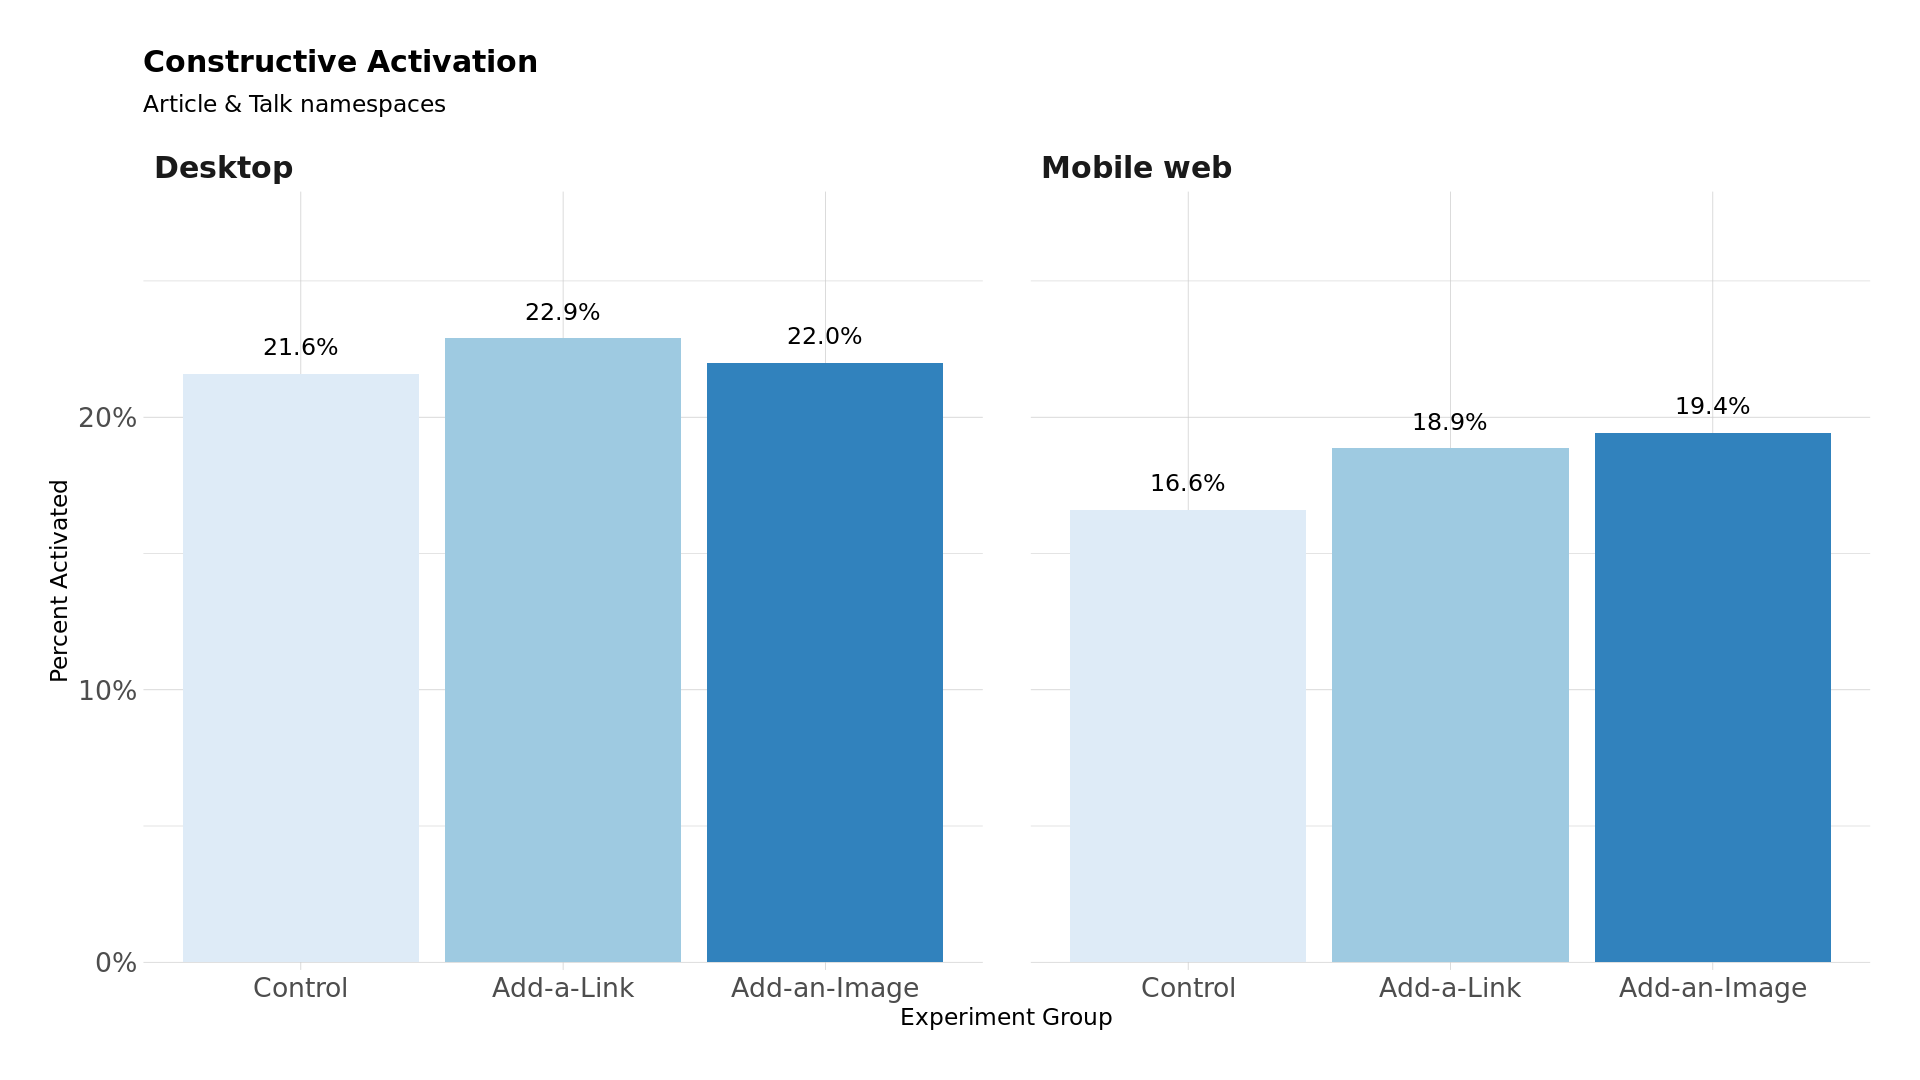

In [149]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 9)
user_edit_data |>
    filter(wiki_db != 'frwiki') |>
    group_by(platform, exp_group, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = exp_group, y = prob, fill = exp_group)) +
        labs(
            title = 'Constructive Activation',
            subtitle = 'Article & Talk namespaces',
            x = 'Experiment Group',
            y = 'Percent Activated') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.28)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.01, size = 5) +
        facet_grid(. ~ platform)
ggsave(
    'add-an-image-article-namespace-constructive-activation-2022-experiment.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")

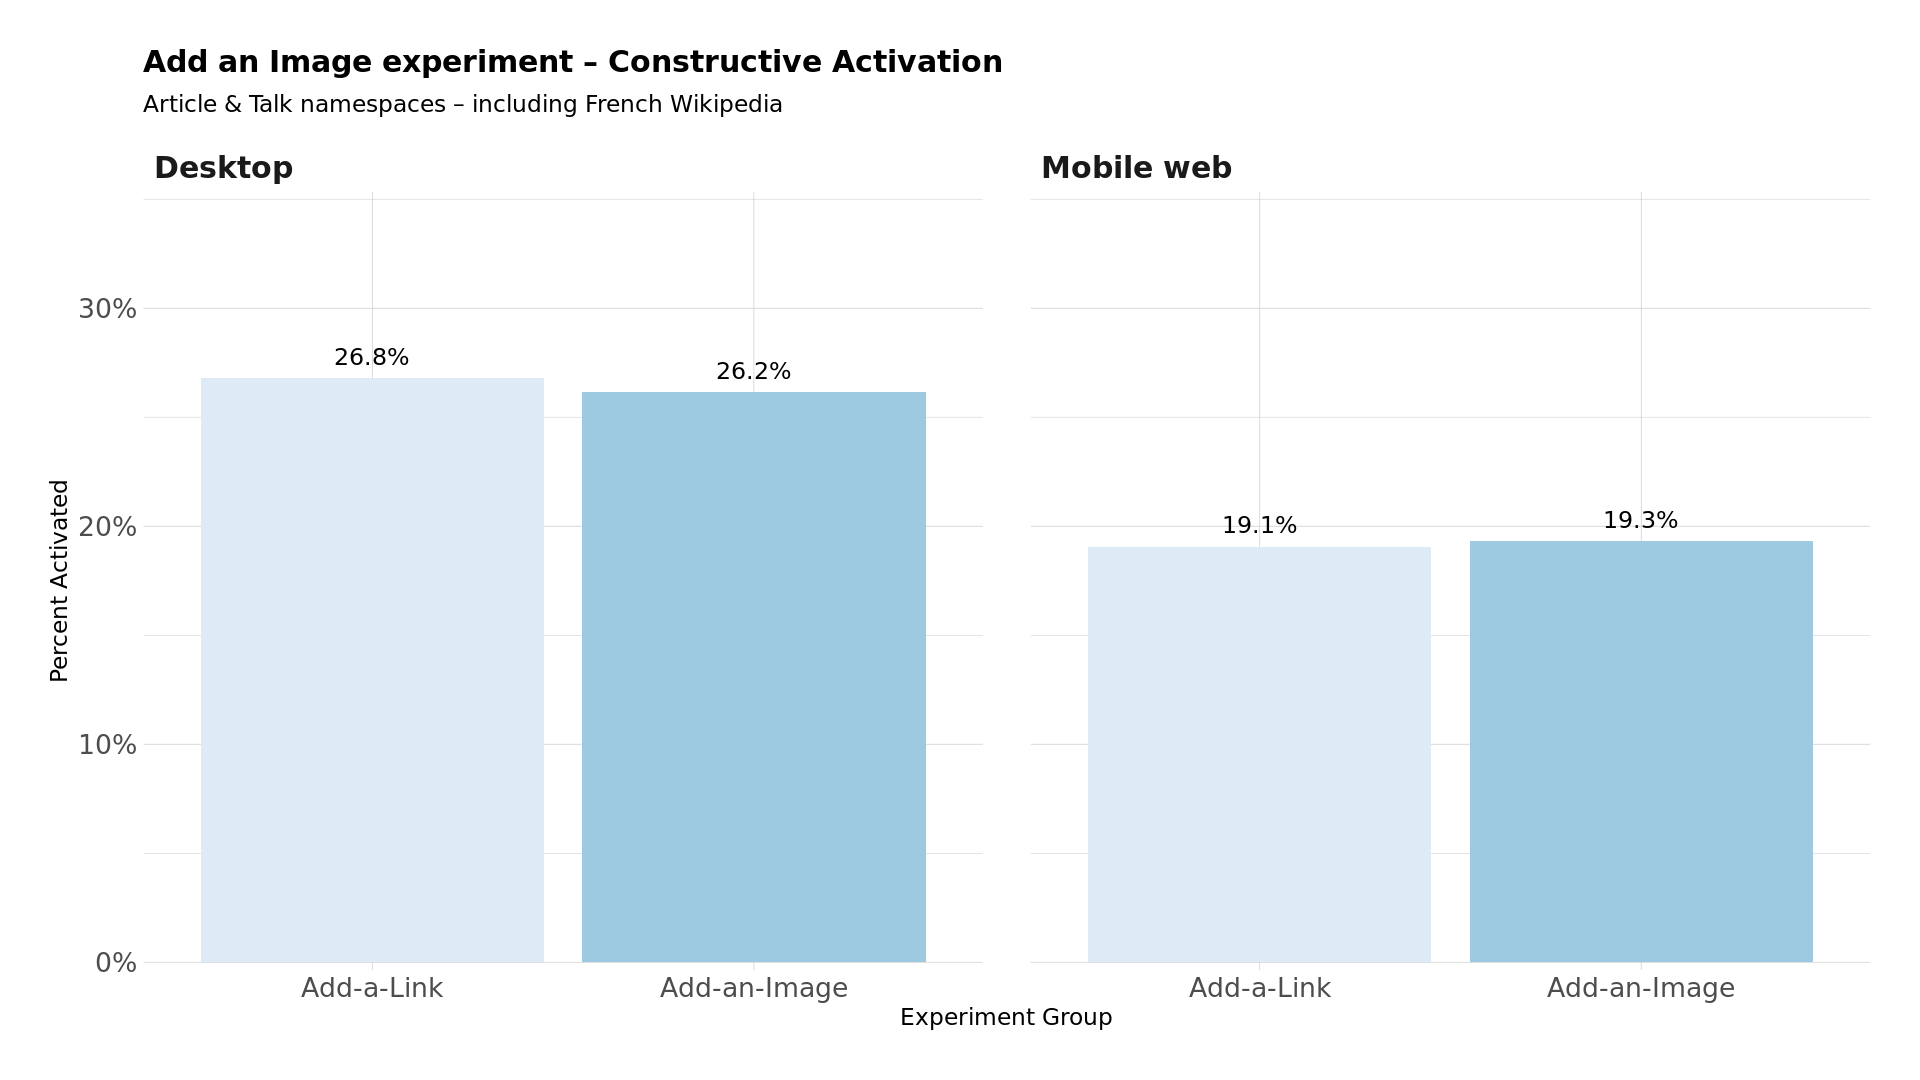

In [14]:
# Give me wider plots, please
options(repr.plot.width = 16, repr.plot.height = 9)
user_edit_data |>
    filter(
        (exp_group != 'Control')
    ) |>
    group_by(platform, exp_group, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = exp_group, y = prob, fill = exp_group)) +
        labs(
            title = 'Add an Image experiment – Constructive Activation',
            subtitle = 'Article & Talk namespaces – including French Wikipedia',
            x = 'Experiment Group',
            y = 'Percent Activated') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.35)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.01, size = 5) +
        facet_grid(. ~ platform)
ggsave(
    'add-an-image-article-namespace-constructive-activation-2022-experiment-structured-tasks.png',
    path = 'graphs',
    width = 16, height = 9, units = "in", dpi = "print", bg = "white")

## Users Per Group

For the report, what's the proportion of users in each group?

In [ ]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)
user_edit_data %>%
    group_by(Group) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group)